In [ ]:
%pip install ipython
%pip install numpy
%pip install pandas
%pip install nbformat
%pip install statsmodels
%pip install mlforecast
%pip install lightgbm
%pip install sktime
%pip install scikit-learn
%pip install matplotlib
%pip install plotly
%pip install holidays

In [2]:
import re
import os
import math
import datetime

import numpy as np
import pandas as pd

import holidays
th_holidays = holidays.TH()
from IPython.display import clear_output

# Visualization
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt

# Data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sktime.transformations.series.outlier_detection import HampelFilter
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error

# Modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from mlforecast import MLForecast
from lightgbm import LGBMRegressor

In [3]:
# Helper functions
def if_work_day(date):
    if ((date in th_holidays) or (date.weekday()>=5)):
        return 0
    else: return 1

stats = pd.DataFrame(columns=['RMSE','MAE','MAPE','EV','RMSLE'])
def get_prediction_stats(actual, prediction, model_name='Model'):
    return pd.DataFrame(
        {
            'RMSE': math.sqrt(mean_squared_error(actual, prediction)),
            'MAE':  mean_absolute_error(actual, prediction),
            'MAPE': mean_absolute_percentage_error(actual, prediction),
            'EV': explained_variance_score(actual, prediction),
            'RMSLE': math.sqrt(mean_squared_log_error(actual, prediction)),
            'Pred Cons (kW)': sum(prediction),
            'Act Cons (kW)': sum(actual),
            '% Diff': (sum(actual) - sum(prediction))/sum(actual)*100
            
        }, index=[model_name]
    )
    
def mark_days_on_plot(fig, days):
    for day in days:
        fig.add_vrect(
            x0=day - datetime.timedelta(hours=12),
            x1=day + datetime.timedelta(hours=12),
            fillcolor="#582156",
            opacity=0.08,
            line_width=0,
        )
    fig.add_annotation(dict(
        font=dict(size=15),
        x=0,
        y=1.1,
        showarrow=False,
        text="Bars mark non-working days",
        textangle=0,
        xanchor='left',
        xref="paper",
        yref="paper"))

    return fig

In [4]:
# Plotly color theme
pio.templates["custom"] = go.layout.Template(
    layout=go.Layout(
        colorway=['#385E88', '#EC008C', '#224E7F', '#AA2070', '#582156'],
        plot_bgcolor='#F8F0E3',
        paper_bgcolor='#F8F0E3'
    )
)
pio.templates.default = 'custom'

In [5]:
# Clean up

# merged_df = pd.read_csv('merged_load_dataset.csv', parse_dates = ['Date']).set_index('Date')

# merged_df[merged_df > 200] = None
# merged_df = merged_df.ffill(limit=60)

# def fill_gaps_with_monthly_avg(series):
#     monthly_avg = series.resample('M').mean()
#     series_filled = series.combine_first(monthly_avg.reindex(series.index))
#     # If there are still NaN values, fill them with the overall mean of the series
#     series_filled = series_filled.fillna(series.mean())
#     return series_filled

# merged_df = merged_df.apply(fill_gaps_with_monthly_avg)

# merged_df = merged_df.resample('H').mean()

# not_ac_columns = [column for column in merged_df.columns if 'AC' not in column]
# transformer = HampelFilter(window_length=12, n_sigma=80) 
# merged_df[not_ac_columns] = transformer.fit_transform(merged_df[not_ac_columns])

# merged_df = merged_df.ffill(limit=12).bfill(limit=12)

# merged_df

In [6]:
merged_df = pd.read_csv('clean_merged_dataset.csv',parse_dates = ['Date']).set_index('Date')

# Combine by type (Light, Plug, AC)
merged_df.columns = [re.sub(r"\d+$", "", column) for column in merged_df.columns]
merged_df = merged_df.groupby(by=merged_df.columns, axis=1).sum()

tuple_columns = [(x[0][-1], x[1][-1], x[2]) for x in [column.split('_') for column in merged_df.columns]]
merged_df.columns = pd.MultiIndex.from_tuples(tuple_columns, names=['Floor', 'Zone','Sensor'])


merged_df = merged_df.resample('D').sum() 
merged_df = merged_df.iloc[:-2] # For clean weeks in testing


total_load_df = merged_df.sum(axis=1)
total_by_zone_df = merged_df.groupby(level=1, axis = 1).sum()
total_by_type_df = merged_df.groupby(level=2, axis = 1).sum()

test_len = 7*12

if_work_day_ts = pd.Series(total_load_df.index.map(if_work_day), index=total_load_df.index)
off_days = if_work_day_ts[-test_len:][if_work_day_ts[-test_len:] == 0].index # For plots


load_train_ts = total_load_df[:-test_len]
load_test_ts = total_load_df[-test_len:]

### Total Load

In [7]:
total_load_df.plot()

#### Stationarity

In [8]:
results_df = pd.DataFrame(columns=['Statistic', 'p-value', 'Result'])
result = sm.tsa.stattools.adfuller(total_load_df)
results_df.loc['ADF',:] = pd.Series({
    'Statistic': result[0],'p-value': result[1],
    'Result': "stationary" if result[1] < 0.05 else "non-stationary"})

result = sm.tsa.stattools.kpss(total_load_df)
results_df.loc['KPSS',:] = pd.Series({
    'Statistic': result[0],'p-value': result[1],
    'Result': "stationary" if result[1] > 0.05 else "non-stationary"})
results_df

,Statistic,p-value,Result
ADF,-4.136509,0.000842,stationary
KPSS,0.456699,0.052716,stationary


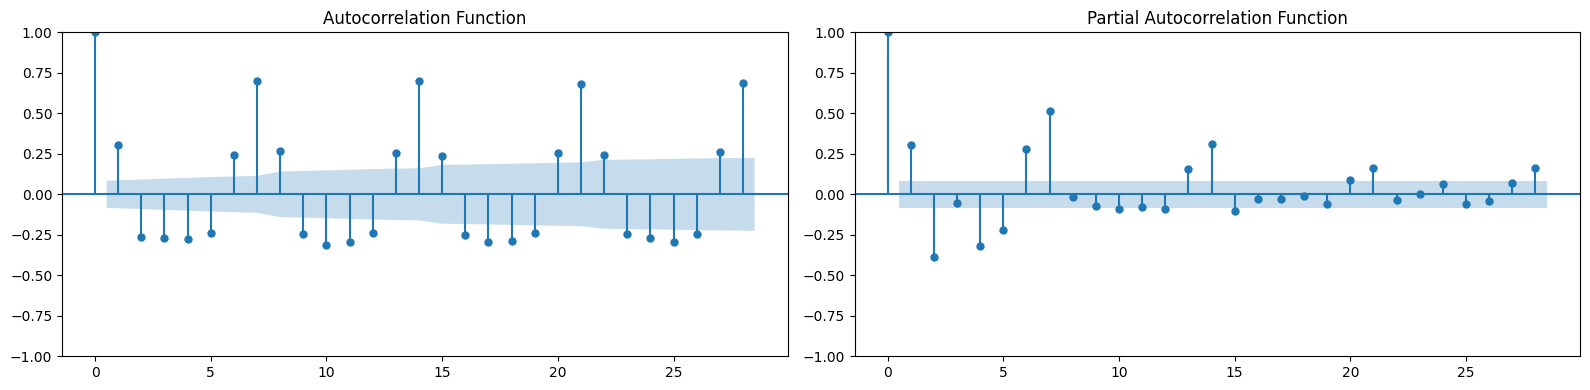

In [9]:
lags = 28

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(total_load_df, lags=lags, ax=axes[0])
axes[0].set_title('Autocorrelation Function')

plot_pacf(total_load_df, lags=lags, ax=axes[1],method='ywm')
axes[1].set_title('Partial Autocorrelation Function')

plt.tight_layout() 
plt.show()

#### Models

##### ARIMA

In [10]:
history = load_train_ts.to_list()
predictions = []

for t_week in range(int(len(load_test_ts) / 7)):
    model = ARIMA(history, order=(14,0,14))
    model_fit = model.fit()
    
    next_pred = model_fit.forecast(steps=7).tolist()
    predictions += next_pred
    history += load_test_ts[t_week*7:(t_week+1)*7].tolist()
    clear_output(wait=False)

In [11]:
model_stats_df = get_prediction_stats(load_test_ts, predictions, 'ARIMA-Total')
stats = stats.append(model_stats_df)
print(model_stats_df)
pd.DataFrame({'Prediction': predictions,
              'Actual': load_test_ts}).plot() 

                    RMSE         MAE      MAPE        EV     RMSLE  \
ARIMA-Total  1102.407191  651.928573  0.160988  0.670518  0.235603   

             Pred Cons (kW)  Act Cons (kW)    % Diff  
ARIMA-Total   489421.787501  469478.831582 -4.247892  


##### SARIMAX

In [12]:
history = load_train_ts.to_list()
predictions = []

for t_week in range(int(len(load_test_ts) / 7)):
    model = SARIMAX(history, exog=if_work_day_ts[:len(history)], order=(14,2,14))
    model_fit = model.fit()
    
    next_pred = model_fit.forecast(steps=7, exog=if_work_day_ts[len(history):len(history)+7]).tolist()
    next_pred = [val if val > min(history) else min(history) for val in next_pred]
    predictions += next_pred
    history += load_test_ts[t_week*7:(t_week+1)*7].tolist()
    clear_output(wait=False)

In [13]:
model_stats_df = get_prediction_stats(load_test_ts, predictions, 'SARIMAX-Total')
stats = stats.append(model_stats_df)
print(model_stats_df)
fig = px.line(pd.DataFrame({'Prediction': predictions,
              'Actual': load_test_ts}))
mark_days_on_plot(fig, off_days)

                   RMSE         MAE      MAPE        EV     RMSLE  \
SARIMAX-Total  529.2784  412.209932  0.080548  0.920607  0.102948   

               Pred Cons (kW)  Act Cons (kW)   % Diff  
SARIMAX-Total   471961.998131  469478.831582 -0.52892  


##### Lightgbm

In [14]:
data = pd.DataFrame(total_load_df).reset_index()
data['Unique Id'] = 'Total Load'
data.columns = ['Date', 'Total Load', 'Unique Id']

data['If Work Day'] = data['Date'].map(if_work_day)

train = data.iloc[:-test_len]
test = data.iloc[-test_len:]

data.head()

,Date,Total Load,Unique Id,If Work Day
0,2018-07-01,3824.578667,Total Load,0
1,2018-07-02,9111.186167,Total Load,1
2,2018-07-03,8103.640000,Total Load,1
3,2018-07-04,7894.746000,Total Load,1
4,2018-07-05,7999.047500,Total Load,1


In [15]:
history = train
predictions = pd.DataFrame([], columns=['Unique Id','Date','LGBMRegressor'])

for t_week in range(int(len(load_test_ts) / 7)):
    models = [LGBMRegressor(random_state=0, n_estimators=500)]

    model = MLForecast(models=models,
                    freq='D',
                    lags=[1,2,4,5,6,7,14,15,20,21,28],
                    num_threads=14)
    
    model.fit(history, id_col='Unique Id', time_col='Date', target_col='Total Load', static_features=[])
    
    next_pred = model.predict(horizon=7, dynamic_dfs=[test[['Date', 'Unique Id', 'If Work Day']]])
    
    predictions = predictions.append(next_pred)
    history = history.append(test.iloc[t_week*7:(t_week+1)*7, :])
    clear_output(wait=False)
    
predictions = predictions.merge(test[['Unique Id', 'Date', 'Total Load', 'If Work Day']], on=['Unique Id', 'Date'], how='left')

In [16]:
model_stats_df = get_prediction_stats(predictions['Total Load'], predictions['LGBMRegressor'], 'LightGBM-Total')
stats = stats.append(model_stats_df)
print(model_stats_df)
fig = px.line(predictions[['Date', 'LGBMRegressor','Total Load']].set_index('Date'))
mark_days_on_plot(fig, off_days)

                      RMSE         MAE      MAPE        EV     RMSLE  \
LightGBM-Total  635.505892  513.133005  0.111714  0.892806  0.139261   

                Pred Cons (kW)  Act Cons (kW)    % Diff  
LightGBM-Total   483235.399402  469478.831582 -2.930179  


### Load by zone

In [17]:
total_by_zone_df.rolling(7).sum().plot()

##### Stationarity

In [18]:
results_df = pd.DataFrame(columns=['Test', 'Zone', 'Statistic', 'p-value', 'Result'])
for column in total_by_zone_df.columns:
    result = sm.tsa.stattools.adfuller(total_by_zone_df[column])
    results_df = results_df.append({
        'Test': 'ADF',
        'Zone': column,
        'Statistic': result[0],
        'p-value': result[1],
        'Result': "stationary" if result[1] < 0.05 else "non-stationary"
    }, ignore_index=True)
    
    result = sm.tsa.stattools.kpss(total_load_df)
    results_df = results_df.append({
        'Test': 'KPSS',
        'Zone': column,
        'Statistic': result[0],
        'p-value': result[1],
        'Result': "stationary" if result[1] > 0.05 else "non-stationary"
    }, ignore_index=True)
results_df.set_index(['Test', 'Zone'], drop=True).unstack(level=0).swaplevel(axis=1).sort_index(axis=1)

Test         ADF                            KPSS                    
          Result Statistic   p-value      Result Statistic   p-value
Zone                                                                
1     stationary -3.570070  0.006360  stationary  0.456699  0.052716
2     stationary -3.281527  0.015725  stationary  0.456699  0.052716
3     stationary -4.173678  0.000730  stationary  0.456699  0.052716
4     stationary -5.189376  0.000009  stationary  0.456699  0.052716
5     stationary -5.390252  0.000004  stationary  0.456699  0.052716

c:\Users\Cyril\Desktop\load-prediction-research-notebook\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



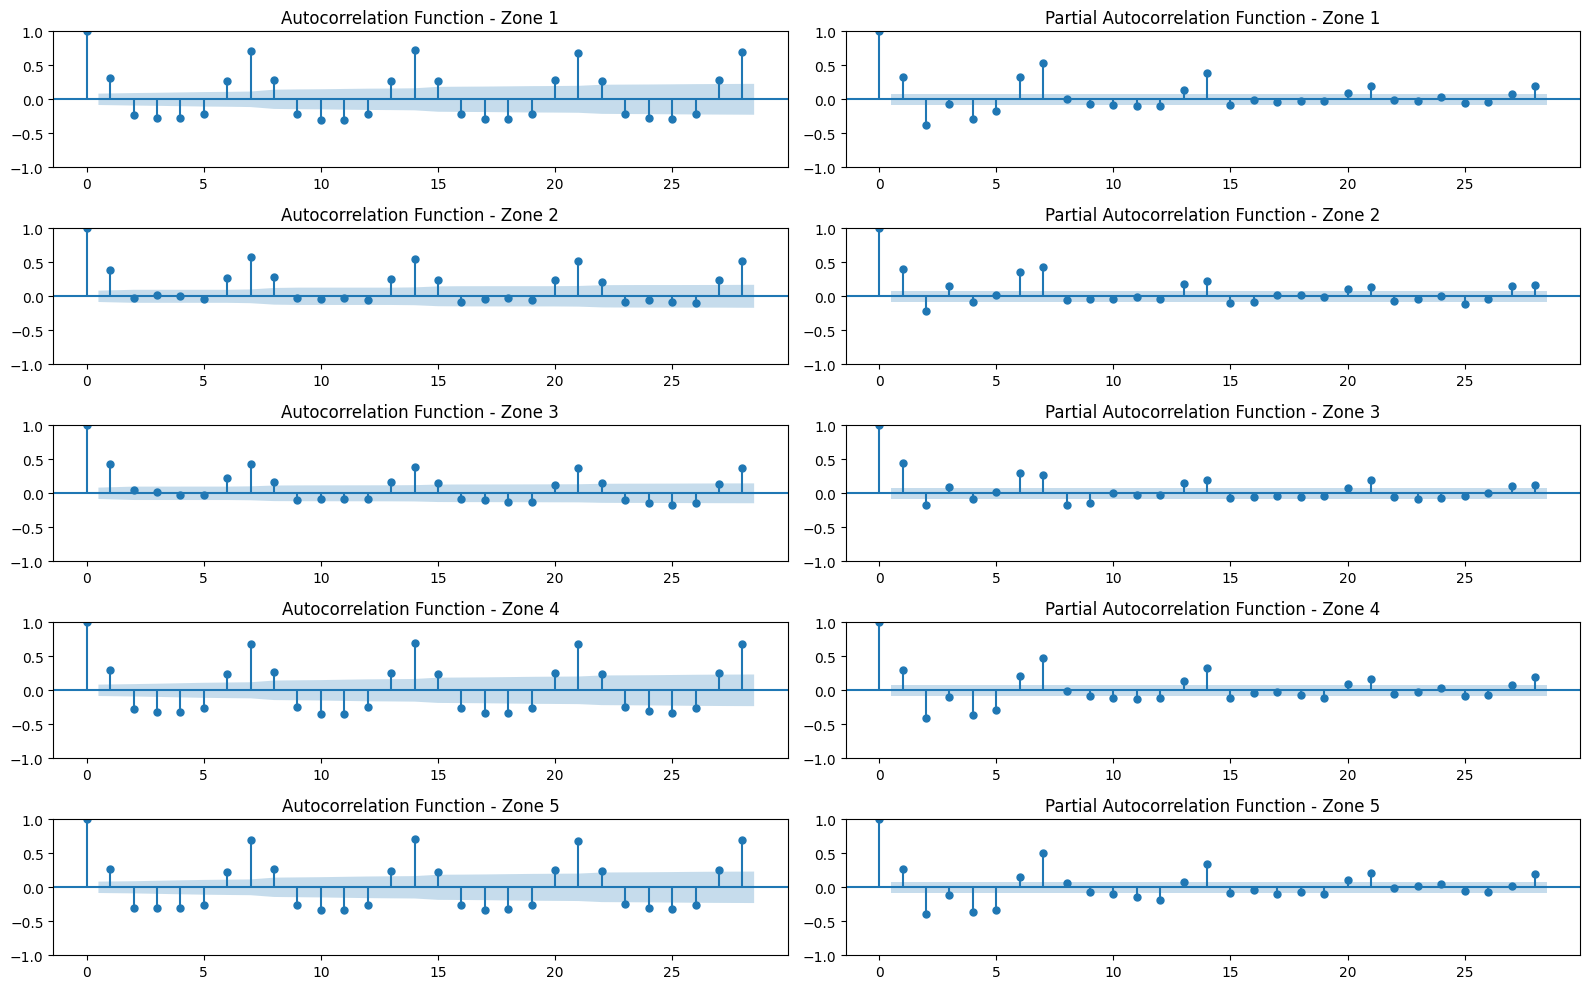

In [19]:
lags = 28
fig, axes = plt.subplots(5, 2, figsize=(16, 10))

for i, column_name in enumerate(total_by_zone_df.columns): 
    plot_acf(total_by_zone_df[column_name], lags=lags, ax=axes[i, 0])
    axes[i, 0].set_title(f'Autocorrelation Function - Zone {column_name}')

    plot_pacf(total_by_zone_df[column_name], lags=lags, ax=axes[i, 1])
    axes[i, 1].set_title(f'Partial Autocorrelation Function - Zone {column_name}')

plt.tight_layout()
plt.show()

#### Models

In [20]:
zone_train_df = total_by_zone_df[:-test_len]
zone_test_df = total_by_zone_df[-test_len:]

##### ARIMA

In [21]:
predictions = []
for col in zone_train_df.columns:
    history = zone_train_df[col].to_list()
    prediction = []
    for t_week in range(int(len(zone_test_df[col]) / 7)):
        model = ARIMA(history, order=(14,1,14))
        model_fit = model.fit()
        
        next_pred = model_fit.forecast(steps=7).tolist()
        prediction += next_pred
        history += zone_test_df[col][t_week*7:(t_week+1)*7].tolist()
        clear_output(wait=False)
    predictions.append(prediction)

predictions = pd.DataFrame(predictions).T
predictions.columns = zone_train_df.columns
total_prediction = predictions.sum(axis=1)

In [22]:
model_stats_df = get_prediction_stats(load_test_ts, total_prediction, 'ARIMA-Zone')
stats = stats.append(model_stats_df)
print(model_stats_df)
pd.DataFrame({'Prediction': total_prediction,
              'Actual': load_test_ts.to_numpy()}).plot()

                   RMSE         MAE      MAPE        EV     RMSLE  \
ARIMA-Zone  1054.124268  631.729795  0.155065  0.691324  0.227932   

            Pred Cons (kW)  Act Cons (kW)    % Diff  
ARIMA-Zone   482873.223934  469478.831582 -2.853034  


In [23]:
fig = make_subplots(rows=predictions.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Zone {col}' for col in predictions.columns])

for i, col in enumerate(predictions.columns):
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=predictions[col], 
               name=f'Zone {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=zone_test_df[col], 
               name=f'Zone {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.show()

##### SARIMAX

In [24]:
predictions = []
for col in zone_train_df.columns:
    history = zone_train_df[col].to_list()
    if_work_day_ts = total_load_df.index.map(if_work_day)
    prediction = []
    for t_week in range(int(len(zone_test_df[col]) / 7)):
        model = SARIMAX(history, exog=if_work_day_ts[:len(history)], order=(14,1,14))
        model_fit = model.fit()
        
        next_pred = model_fit.forecast(steps=7, exog=if_work_day_ts[len(history):len(history)+7]).tolist()
        next_pred = [val if val > min(history) else min(history) for val in next_pred]
        prediction += next_pred
        history += zone_test_df[col][t_week*7:(t_week+1)*7].tolist()
        clear_output(wait=False)
    predictions.append(prediction)
    
predictions = pd.DataFrame(predictions).T
predictions.columns = zone_train_df.columns
total_prediction = predictions.sum(axis=1)

In [25]:
model_stats_df=get_prediction_stats(load_test_ts, total_prediction, 'SARIMAX-Zone')
stats = stats.append(model_stats_df)
print(model_stats_df)

fig = px.line(pd.DataFrame({'Prediction': total_prediction.to_numpy(),
              'Actual': load_test_ts.to_numpy()}, index = load_test_ts.index))
mark_days_on_plot(fig, off_days)

                    RMSE        MAE      MAPE        EV     RMSLE  \
SARIMAX-Zone  502.793341  389.10588  0.073441  0.928506  0.091604   

              Pred Cons (kW)  Act Cons (kW)  % Diff  
SARIMAX-Zone   472537.485667  469478.831582 -0.6515  


In [26]:
fig = make_subplots(rows=predictions.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Zone {col}' for col in predictions.columns])

for i, col in enumerate(predictions.columns):
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=predictions[col], 
               name=f'Zone {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=zone_test_df[col], 
               name=f'Zone {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.update_layout(plot_bgcolor='#F8F0E3',
                  paper_bgcolor='#F8F0E3')
fig.update_xaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
fig.update_yaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
mark_days_on_plot(fig, off_days)

##### Lightgbm

In [27]:
data = total_by_zone_df.reset_index()

train = data.iloc[:-test_len]
test = data.iloc[-test_len:]

train = pd.wide_to_long(train, 
                       stubnames='', i=['Date'], j='Unique Id').reset_index()
train.columns = ['Date', 'Unique Id', 'Load']
train['If Work Day'] = train['Date'].map(if_work_day)


test = pd.wide_to_long(test, 
                       stubnames='', i=['Date'], j='Unique Id').reset_index()
test.columns = ['Date', 'Unique Id', 'Load']
test['If Work Day'] = test['Date'].map(if_work_day)

In [28]:
history = train
predictions = pd.DataFrame([], columns=['Unique Id','Date','LGBMRegressor'])

for t_week in range(int(len(load_test_ts) / 7)):
    models = [LGBMRegressor(random_state=0, n_estimators=500)]

    model = MLForecast(models=models,
                    freq='D',
                    lags=[1,2,4,5,6,7,8,9,12,13,14,21,28],
                    num_threads=14)
    
    model.fit(history, id_col='Unique Id', time_col='Date', target_col='Load', static_features=[])
    
    next_pred = model.predict(horizon=7, dynamic_dfs=[test[['Date', 'Unique Id', 'If Work Day']]])
    
    predictions = predictions.append(next_pred)
    history = history.append(test[test['Date'].isin(next_pred['Date'].unique())])
    clear_output(wait=False)
    
predictions = predictions.merge(test[['Unique Id', 'Date', 'Load', 'If Work Day']], 
                                on=['Unique Id', 'Date'], how='left')
predictions = predictions.reset_index()

total_prediction = predictions[['Date','LGBMRegressor', 'Load']].groupby(['Date']).sum()
predictions = predictions.pivot(index='Date', columns='Unique Id', values='LGBMRegressor')
predictions.columns = predictions.columns.map(str)

In [29]:
model_stats_df = get_prediction_stats(total_prediction['Load'], total_prediction['LGBMRegressor'], 'LightGBM-Zone')
stats = stats.append(model_stats_df)
print(model_stats_df)
fig = px.line(total_prediction)
mark_days_on_plot(fig, off_days)

                    RMSE         MAE      MAPE        EV    RMSLE  \
LightGBM-Zone  504.72414  413.332404  0.083264  0.928836  0.10868   

               Pred Cons (kW)  Act Cons (kW)    % Diff  
LightGBM-Zone    475070.41237  469478.831582 -1.191019  


In [31]:
fig = make_subplots(rows=predictions.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Zone {col}' for col in predictions.columns])

for i, col in enumerate(predictions.columns):
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=predictions[col], 
               name=f'Zone {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=zone_test_df.index, y=zone_test_df[col], 
               name=f'Zone {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.update_layout(plot_bgcolor='#F8F0E3',
                  paper_bgcolor='#F8F0E3')
fig.update_xaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
fig.update_yaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
mark_days_on_plot(fig, off_days)

### Load by type

In [32]:
total_by_type_df.rolling(7).sum().plot()

##### Stationarity

In [33]:
results_df = pd.DataFrame(columns=['Test', 'Type', 'Statistic', 'p-value', 'Result'])
for column in total_by_type_df.columns:
    result = sm.tsa.stattools.adfuller(total_by_type_df[column])
    results_df = results_df.append({
        'Test': 'ADF',
        'Type': column,
        'Statistic': result[0],
        'p-value': result[1],
        'Result': "stationary" if result[1] < 0.05 else "non-stationary"
    }, ignore_index=True)
    
    result = sm.tsa.stattools.kpss(total_load_df)
    results_df = results_df.append({
        'Test': 'KPSS',
        'Type': column,
        'Statistic': result[0],
        'p-value': result[1],
        'Result': "stationary" if result[1] > 0.05 else "non-stationary"
    }, ignore_index=True)
results_df.set_index(['Test', 'Type'], drop=True).unstack(level=0).swaplevel(axis=1).sort_index(axis=1)

Test              ADF                            KPSS                    
               Result Statistic   p-value      Result Statistic   p-value
Type                                                                     
AC         stationary -3.276702  0.015953  stationary  0.456699  0.052716
Light      stationary -3.143422  0.023502  stationary  0.456699  0.052716
Plug   non-stationary -2.613503  0.090238  stationary  0.456699  0.052716

c:\Users\Cyril\Desktop\load-prediction-research-notebook\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



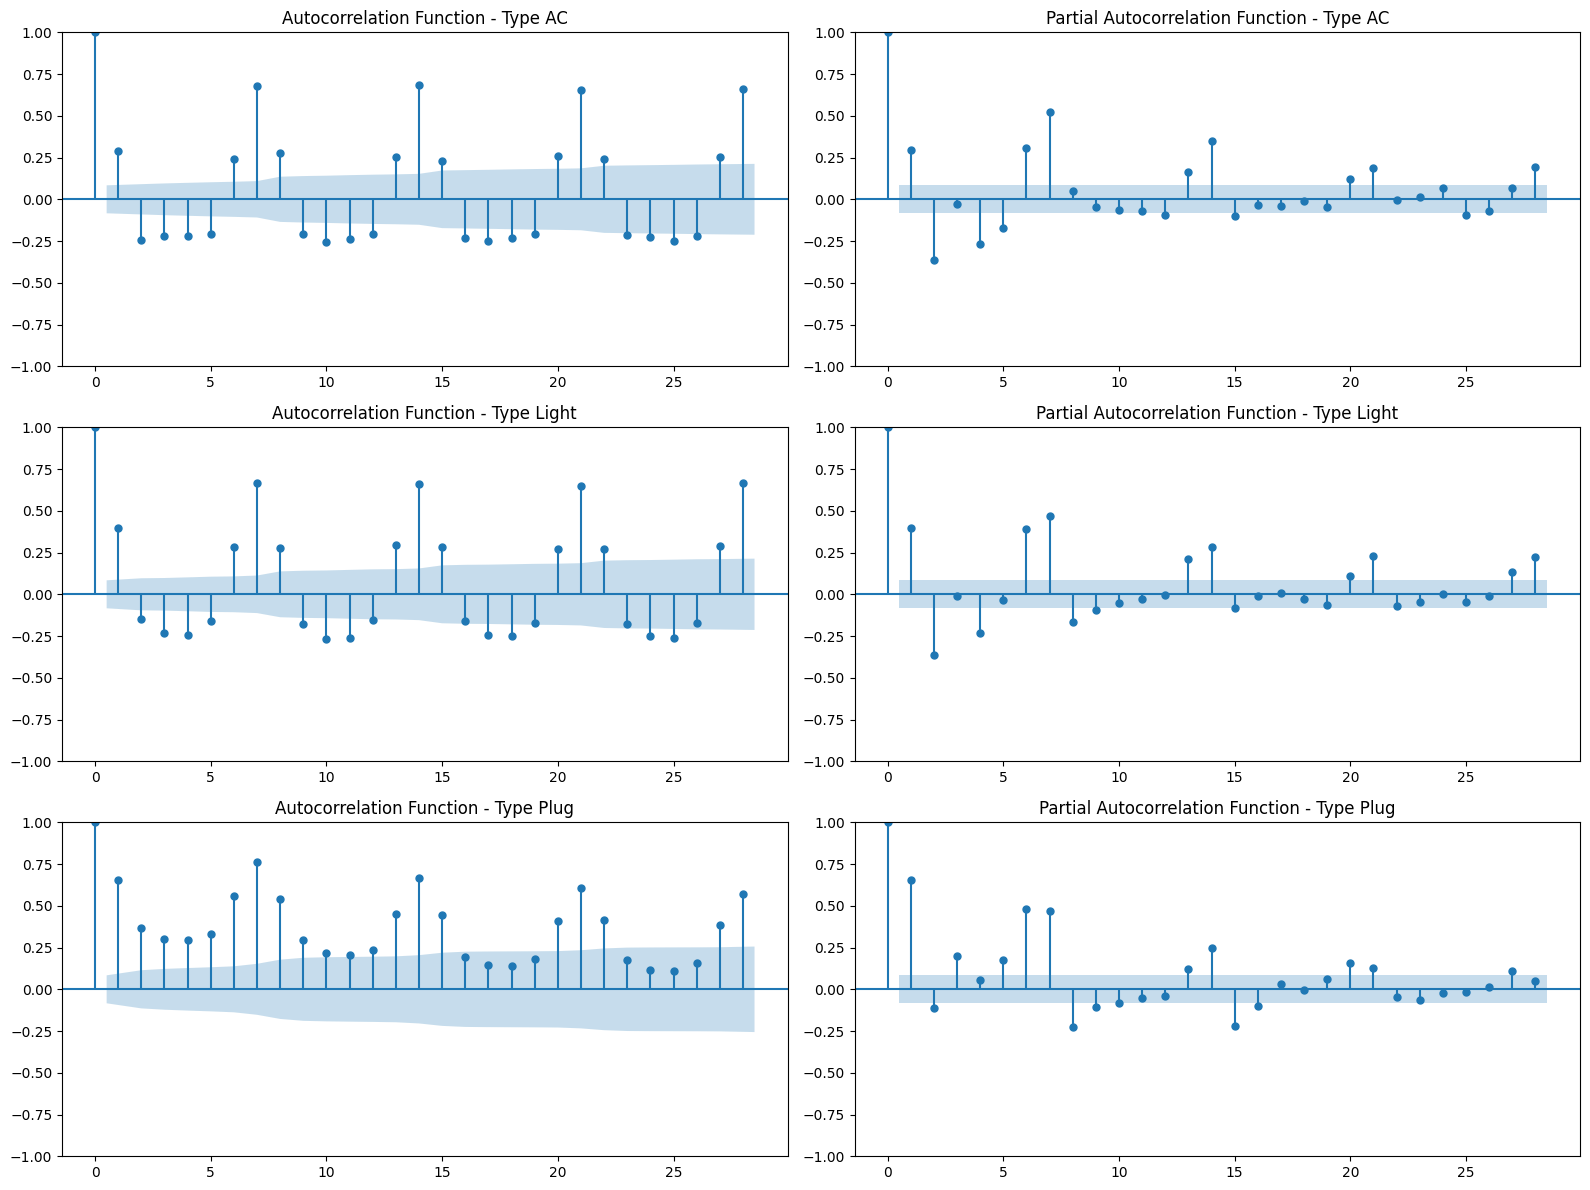

In [34]:
lags = 28
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for i, column_name in enumerate(total_by_type_df.columns): 
    plot_acf(total_by_type_df[column_name], lags=lags, ax=axes[i, 0])
    axes[i, 0].set_title(f'Autocorrelation Function - Type {column_name}')

    plot_pacf(total_by_type_df[column_name], lags=lags, ax=axes[i, 1])
    axes[i, 1].set_title(f'Partial Autocorrelation Function - Type {column_name}')

plt.tight_layout()
plt.show()

#### Models

In [35]:
type_train_df = total_by_type_df[:-test_len]
type_test_df = total_by_type_df[-test_len:]

##### ARIMA

In [36]:
predictions = []
for col in type_train_df.columns:
    history = type_train_df[col].to_list()
    prediction = []
    for t_week in range(int(len(type_test_df[col]) / 7)):
        model = ARIMA(history, order=(14,1,14))
        model_fit = model.fit()
        
        next_pred = model_fit.forecast(steps=7).tolist()
        prediction += next_pred
        history += type_test_df[col][t_week*7:(t_week+1)*7].tolist()
        clear_output(wait=False)
    predictions.append(prediction)

predictions = pd.DataFrame(predictions).T
predictions.columns = type_train_df.columns
total_prediction = predictions.sum(axis=1)

In [37]:
model_stats_df=get_prediction_stats(load_test_ts, total_prediction, 'ARIMA-Type')
stats = stats.append(model_stats_df)
print(model_stats_df)
pd.DataFrame({'Prediction': total_prediction,
              'Actual': load_test_ts.to_numpy()}).plot()

                   RMSE         MAE      MAPE        EV     RMSLE  \
ARIMA-Type  1090.794053  681.499169  0.163406  0.674784  0.231618   

            Pred Cons (kW)  Act Cons (kW)    % Diff  
ARIMA-Type   487475.995205  469478.831582 -3.833435  


In [38]:
fig = make_subplots(rows=predictions.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Type {col}' for col in predictions.columns])

for i, col in enumerate(predictions.columns):
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=predictions[col], 
               name=f'Type {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=type_test_df[col], 
               name=f'Type {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.update_layout(plot_bgcolor='#F8F0E3',
                  paper_bgcolor='#F8F0E3')
fig.update_xaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
fig.update_yaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')

##### SARIMAX

In [39]:
predictions = []
for col in type_train_df.columns:
    history = type_train_df[col].to_list()
    if_work_day_ts = total_load_df.index.map(if_work_day)
    prediction = []
    for t_week in range(int(len(type_test_df[col]) / 7)):
        model = SARIMAX(history, exog=if_work_day_ts[:len(history)], order=(14,2,14))
        model_fit = model.fit()
        
        next_pred = model_fit.forecast(steps=7, exog=if_work_day_ts[len(history):len(history)+7]).tolist()
        next_pred = [val if val > min(history) else min(history) for val in next_pred]
        prediction += next_pred
        history += type_test_df[col][t_week*7:(t_week+1)*7].tolist()
        clear_output(wait=False)
    predictions.append(prediction)
    
predictions = pd.DataFrame(predictions).T
predictions.columns = type_train_df.columns
total_prediction = predictions.sum(axis=1)

In [40]:
model_stats_df=get_prediction_stats(load_test_ts, total_prediction, 'SARIMAX-Type')
stats = stats.append(model_stats_df)
print(model_stats_df)
fig = px.line(pd.DataFrame({'Prediction': total_prediction.to_numpy(),
              'Actual': load_test_ts.to_numpy()}, index = load_test_ts.index))
mark_days_on_plot(fig, off_days)

                    RMSE         MAE      MAPE        EV     RMSLE  \
SARIMAX-Type  499.526266  394.582638  0.074871  0.929061  0.092802   

              Pred Cons (kW)  Act Cons (kW)    % Diff  
SARIMAX-Type   469389.373964  469478.831582  0.019055  


In [41]:
fig = make_subplots(rows=predictions.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Type {col}' for col in predictions.columns])

for i, col in enumerate(predictions.columns):
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=predictions[col], 
               name=f'Type {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=type_test_df[col], 
               name=f'Type {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.update_layout(plot_bgcolor='#F8F0E3',
                  paper_bgcolor='#F8F0E3')
fig.update_xaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
fig.update_yaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
mark_days_on_plot(fig, off_days)

##### Lightgbm

In [42]:
data = total_by_type_df.reset_index()

train = data.iloc[:-test_len]
test = data.iloc[-test_len:]

train = pd.wide_to_long(train, stubnames='', 
                       i=['Date'], j='unique_id', 
                       suffix='(AC|Light|Plug)').reset_index()
train.columns = ['Date', 'Unique Id', 'Load']
train['If Work Day'] = train['Date'].map(if_work_day)


test = pd.wide_to_long(test, stubnames='', 
                       i=['Date'], j='unique_id', 
                       suffix='(AC|Light|Plug)').reset_index()
test.columns = ['Date', 'Unique Id', 'Load']
test['If Work Day'] = test['Date'].map(if_work_day)

In [43]:
history = train
predictions = pd.DataFrame([], columns=['Unique Id','Date','LGBMRegressor'])

for t_week in range(int(len(load_test_ts) / 7)):
    models = [LGBMRegressor(random_state=0, n_estimators=500)]

    model = MLForecast(models=models,
                    freq='D',
                    lags=[1,2,4,5,6,7,8,9,12,13,14,21,28],
                    num_threads=14)
    
    model.fit(history, id_col='Unique Id', time_col='Date', target_col='Load', static_features=[])
    
    next_pred = model.predict(horizon=7, dynamic_dfs=[test[['Date', 'Unique Id', 'If Work Day']]])
    
    predictions = predictions.append(next_pred)
    history = history.append(test[test['Date'].isin(next_pred['Date'].unique())])
    clear_output(wait=False)
    
predictions = predictions.merge(test[['Unique Id', 'Date', 'Load', 'If Work Day']], 
                                on=['Unique Id', 'Date'], how='left')
predictions = predictions.reset_index()

total_prediction = predictions[['Date','LGBMRegressor', 'Load']].groupby(['Date']).sum()
predictions = predictions.pivot(index='Date', columns='Unique Id', values='LGBMRegressor')
predictions.columns = predictions.columns.map(str)

In [44]:
model_stats_df=get_prediction_stats(total_prediction['Load'], total_prediction['LGBMRegressor'], 'LightGBM-Type')
stats = stats.append(model_stats_df)
print(model_stats_df)
fig = px.line(total_prediction)
mark_days_on_plot(fig, off_days)

                     RMSE         MAE      MAPE        EV    RMSLE  \
LightGBM-Type  551.510809  447.144484  0.092901  0.915723  0.11678   

               Pred Cons (kW)  Act Cons (kW)    % Diff  
LightGBM-Type    476861.26806  469478.831582 -1.572475  


In [45]:
fig = make_subplots(rows=predictions.shape[1], cols=1, 
                    shared_xaxes=True, vertical_spacing=0.03,
                    subplot_titles = [f'Type {col}' for col in predictions.columns])

for i, col in enumerate(predictions.columns):
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=predictions[col], 
               name=f'Type {col}: Pred', line_color='#385E88',
               mode='lines'),
    row=i+1, col=1)
    fig.add_trace(
    go.Scatter(x=type_test_df.index, y=type_test_df[col], 
               name=f'Type {col}: Actual', line_color='#EC008C',
               mode='lines'),
    row=i+1, col=1)
fig.update_layout(
    height=1000,)
fig.update_layout(plot_bgcolor='#F8F0E3',
                  paper_bgcolor='#F8F0E3')
fig.update_xaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
fig.update_yaxes(showline=False, linewidth=2, gridcolor='#D5D2DA', zerolinecolor='#D5D2DA')
mark_days_on_plot(fig, off_days)

In [46]:
px.bar(stats['MAPE'].sort_values(ascending=False))

In [47]:
stats_copy = stats.copy()
stats_copy.index = stats.index.str.split('-', expand=True)
stats_copy.reset_index(inplace=True)
stats_copy.columns = (['Model', 'Ensamble By'] + list(stats_copy.columns[2:]))
stats_copy = stats_copy.set_index(['Model', 'Ensamble By']).unstack(['Ensamble By']).T
stats_copy = stats_copy.reorder_levels([1,0]).sort_index()
stats_copy

Model                               ARIMA       LightGBM        SARIMAX
Ensamble By                                                            
Total       % Diff              -4.247892      -2.930179      -0.528920
            Act Cons (kW)   469478.831582  469478.831582  469478.831582
            EV                   0.670518       0.892806       0.920607
            MAE                651.928573     513.133005     412.209932
            MAPE                 0.160988       0.111714       0.080548
            Pred Cons (kW)  489421.787501  483235.399402  471961.998131
            RMSE              1102.407191     635.505892     529.278400
            RMSLE                0.235603       0.139261       0.102948
Type        % Diff              -3.833435      -1.572475       0.019055
            Act Cons (kW)   469478.831582  469478.831582  469478.831582
            EV                   0.674784       0.915723       0.929061
            MAE                681.499169     447.144484     394.582638
            MAPE                 0.163406       0.092901       0.074871
            Pred Cons (kW)  487475.995205  476861.268060  469389.373964
            RMSE              1090.794053     551.510809     499.526266
            RMSLE                0.231618       0.116780       0.092802
Zone        % Diff              -2.853034      -1.191019      -0.651500
            Act Cons (kW)   469478.831582  469478.831582  469478.831582
            EV                   0.691324       0.928836       0.928506
            MAE                631.729795     413.332404     389.105880
            MAPE                 0.155065       0.083264       0.073441
            Pred Cons (kW)  482873.223934  475070.412370  472537.485667
            RMSE              1054.124268     504.724140     502.793341
            RMSLE                0.227932       0.108680       0.091604

In [48]:
fig = make_subplots(rows=stats.shape[1], cols=1, vertical_spacing=0.05,
                    subplot_titles = [f'{col}' for col in stats.columns])

for i, col in enumerate(stats.columns):
    fig.add_trace(
    go.Bar(x=stats[col].sort_values(ascending=False).index, y=stats[col].sort_values(ascending=False)),row=i+1, col=1)
fig.update_layout(
    height=1200,)